L'objectif de ce TP est de réimplémenter vous-mêmes le modèle décrit dans la publication scientifique suivante : 

- https://www.frontiersin.org/journals/applied-mathematics-and-statistics/articles/10.3389/fams.2022.836349/full

C'est à vous !

### Reprise pas à pas des éléments du modèle exposé au tableau le deuxième jour

Par rapport au modèle de prédiction de données météo, nous devons changer de paradigme. En effet, nous ne sommes pas capables d'observer directement la vraie concentration d'un pathogène dans les eaux usées.

Le premier élément qui va changer est l'espace des états discrets $\mathcal{X}$. Sur le problème de météo, nous avions 3 états. Ici, nous cherchons à discrétiser l'ensemble des valeurs de concentrations qui nous intéressent sur $\mathbb{R}$. Bien évidemment, on ne va pas chercher à discrétiser tout l'espace des réels, uniquement les valeurs qui ont du sens par rapport à la série de données qui nous intéresse.

Concrètement, par rapport à un nuage d'observations, la variable latente d'intérêt se situera parfois en-dessous et parfois au dessus de ce nuage, le reste du temps, elle vivra à l'intérieur du nuage. Il est donc raisonnable de prendre comme bornes de discrétisation $$[\min(\hat{X}) - 2\text{std}(\hat{X}), \max(\hat{X}) + 2\text{std}(\hat{X})]$$

**Comment coder cela ?**

In [ ]:
def get_X_ronde(self):
    self.obs_std = np.nanstd(self.observations)
    self.borne_inf, self.borne_sup = np.nanmin(self.observations) - 2*self.obs_std, np.nanmax(self.observations) + 2*self.obs_std

    self.discretization_step = (self.borne_sup - self.borne_inf) / self.nb_states
    self.X_ronde = np.arange(self.borne_inf, self.borne_sup, self.discretization_step)
    self.nb_states = self.X_ronde.shape[0] # because of how np.arange works, this can sometimes lead to an extra state, which is acceptable

La première ligne permet de calculer l'écart-type. La seconde ligne définit les bornes a et b de la publication précédente. La troisième ligne permet de définir le pas de discrétisation, en fonction d'un nombre d'états fixé (self.nb_states, seul hyperparamètre de l'algorithme). Le pas de discrétisation correspond à $\frac{b-a}{\text{nb\_states}}$.
La ligne suivante permet donc de générer $\mathcal{X}$ à l'aide de la fonction np.arange.

Enfin, la dernière ligne sert de sécurité dans le code : elle remet à jour le nombre d'états, si jamais la taille de $\mathcal{X}$ obtenue à la ligne du dessus dépasse celle initialement voulue, ce qui peut parfois survenir.

De la même manière, on doit également définir $\mathcal{T}$, qui correspond à l'ensemble des pas de temps où on a récolté une observation.

**Comment coder cela ?**

In [ ]:
def get_T_ronde(self):
    self.T_ronde = np.where(~np.isnan(self.observations))[0]

Une seule ligne suffit : on cherche les index de l'attribut de classe self.observations qui ne sont pas des valeurs NaN (not a number) car, si une observation a été récoltée, on aura une valeur numérique à cet emplacement.

Par rapport à la publication précédemment citée, nous allons simplifier le modèle. On considère que la vraie concentration d'un pathogène dans les eaux usées, **une fois transformée en échelle logarithmique**, suit une marche aléatoire Gaussienne de premier ordre.

En d'autres termes :

$$ X_t = X_{t-1} + \mathcal{N}(0, \sigma^2) $$

**Qu'est-ce que cela signifie ?** Cela signifie que, pour obtenir $X_t$, on va copier la valeur de $X_{t-1}$ et rajouter une petite variation. Cette variation sera issue d'une loi normale de moyenne nulle et d'écart-type $\sigma$. En d'autre termes, la concentration de pathogène entre un jour $t-1$ et un jour $t$ va en moyenne varier d'un ordre de grandeur égal à $\sigma$. 

On peut également écrire l'équation de la manière suivante : 

$$ X_t = \mathcal{N}(X_{t-1}, \sigma^2) $$

En d'autres termes, pour obtenir la valeur de X_t, on se place au niveau de $X_{t-1}$, et on rajoute une dispersion stochastique. En moyenne, la dispersion de $X_t$ autour de $X_{t-1}$ vaut $\sigma$.


Cette modélisation du processus latent $\boldsymbol{X}$ a pour conséquence que $\mathcal{P}(X_t|X_{t-1}) = \frac{1}{\sqrt{2\pi}\sigma} \exp[-\frac{1}{2}(\frac{X_t - X_{t-1}}{\sigma})^2]$. Et pour rappel, la probabilité $\mathcal{P}(X_t|X_{t-1})$ est la probabilité que la chaîne de Markov représentant la variable latente transitionne de l'état $X_{t-1}$ à l'état $X_t$. C'est donc la définition d'une cellule de la matrice de transition ! 

$$a_{ij} = \mathcal{P}(X_t=x_j|X_{t-1}=x_j)$$

**Comment coder cela ?**

In [ ]:
def compute_transition_matrix(self):
    self.transition_matrix = ss.norm.pdf(self.X_ronde[:, np.newaxis], self.X_ronde, self.sigma)
    self.transition_matrix /= self.transition_matrix.sum(axis=1)[:, np.newaxis]

La première ligne code exactement l'expression $a_{ij} = \mathcal{P}(X_t=x_j|X_{t-1}=x_j)$. La deuxième ligne s'assure que la matrice est bien stochastique par ligne.

On peut maintenant passer à la matrice d'émission, qui est une nouveauté par rapport au précédent TP, car nous n'avions pas de matrice d'émission dans la cas d'un simple modèle de chaîne de Markov.

**Quel est le rôle de la matrice d'émission ?**

Le rôle de la matrice d'émission est de modéliser la manière dont les observations vivent autour de la variable latente. Il y a pour cela 4 possibilités dans notre cas de figure :

- observation classique non censurée : c'est l'observation standard. L'échantillon présente un certain bruit de mesure (dû à la fois à l'échantillonnage en station et à la quantification par une méthode comme la RT-qPCR), mais la quantification était supérieure à la limite de détection : il n'est pas censuré.
- observation anormale non censurée : l'échantillon présente un bruit de mesure anormal (problème lors de l'échantillonnage en station, contamination de l'échantillon, problème lors des processus d'extraction, concentration ou quantification par PCR), mais la quantification était supérieure à la limite de détection : il n'est pas censuré, mais c'est une anomalie.
- observation classique censurée : L'échantillon présente un certain bruit de mesure (dû à la fois à l'échantillonnage en station et à la quantification par une méthode comme la RT-qPCR) et la quantification est inférieure ou égale à à la limite de détection : il est censuré, et il s'agit d'une anomalie.
- observation anormale censurée : l'échantillon présente un bruit de mesure anormal (problème lors de l'échantillonnage en station, contamination de l'échantillon, problème lors des processus d'extraction, concentration ou quantification par PCR) et la quantification est inférieure ou égale à la limite de détection : il est censuré, et il s'agit d'une anomalie.

**Comment coder cela ?**

In [ ]:
def get_outlier_emission_parts(self):
    self.outlier_part_censored = (self.lod_vect[self.observations_below_LoD] - self.borne_inf) / (self.borne_sup - self.borne_inf)
    self.outlier_part_uncensored = np.ones(self.observations_above_LoD.shape[0]) / (self.borne_sup - self.borne_inf)

Pour modéliser la matrice d'émission, on utilise ce que l'on appelle un modèle de mélange : la probabilité d'observer $\hat{X_t}$ conditionnellement à $X_t$ est un mélange entre une loi normale et une loi uniforme. Les paramètres de la loi uniforme étant uniquement a, b et l, on peut les coder à l'extérieur pour ne pas répéter inutilement les calculs. C'est pour cela que l'on sépare les calculs dans deux fonctions. Une fois que ces calculs sont faits, on peut passer au coeur de la fonction de la matrice d'émission :

In [ ]:
def compute_emission_matrix(self):
    self.emission_matrix = np.empty((self.observations.shape[0], self.X_ronde.shape[0]))
    self.emission_matrix[:] = np.nan

    self.emission_matrix[self.observations_above_LoD] = (1 - self.p_out) * ss.norm.pdf(self.observations[self.observations_above_LoD, np.newaxis], self.X_ronde, self.epsilon)
    self.emission_matrix[self.observations_above_LoD] += self.p_out * self.outlier_part_uncensored[:, np.newaxis]

    self.emission_matrix[self.observations_below_LoD] = (1 - self.p_out) * ss.norm.cdf(self.lod_vect[self.observations_below_LoD, np.newaxis], self.X_ronde, self.epsilon)
    self.emission_matrix[self.observations_below_LoD] += self.p_out * self.outlier_part_censored[:, np.newaxis]

    self.emission_matrix[np.where(np.isnan(self.observations))] = 1.0 # dealing with unobserved timestamps

Le premier bloc de deux lignes permet d'initialiser la matrice. Elle est de taille (n,D), où n est le nombre de pas de temps, et D le nombre de pas de discrétisation (le cardinal de $\mathcal{X}$).

Les deux lignes suivante permettent de coder la probabilité d'émission dans le cas où la quantification était strictement supérieure à la LoD : 

- soit l'échantillon était une observation classique non censurée :

In [ ]:
self.emission_matrix[self.observations_above_LoD] = (1 - self.p_out) * ss.norm.pdf(self.observations[self.observations_above_LoD, np.newaxis], self.X_ronde, self.epsilon)

- soit il s'agit d'une observation anormale non censurée : 

In [ ]:
self.emission_matrix[self.observations_above_LoD] += self.p_out * self.outlier_part_uncensored[:, np.newaxis]

On traite alors les données censurées :

- soit l'échantillon était une observation classique censurée :

In [ ]:
self.emission_matrix[self.observations_below_LoD] = (1 - self.p_out) * ss.norm.cdf(self.lod_vect[self.observations_below_LoD, np.newaxis], self.X_ronde, self.epsilon)

- soit il s'agit d'une observation anormale censurée : 

In [ ]:
self.emission_matrix[self.observations_below_LoD] += self.p_out * self.outlier_part_censored[:, np.newaxis]

Enfin, si on n'observe rien, la probabilité est de 1.0 

In [ ]:
self.emission_matrix[np.where(np.isnan(self.observations))] = 1.0 # dealing with unobserved timestamps

On peut maintenant passer à la matrice Forward ! 

**Quel est le rôle de la matrice Forward ?**

Comme on l'a vu lors du deuxième jour, pour obtenir une estimation des paramètres du modèle, on va chercher à maximiser ce que l'on appelle la fonction de vraisemblance (likelihood en anglais) :

$$ \mathcal P_{\boldsymbol{\theta}}(\hat{\boldsymbol{X}}) $$

L'intérêt de l'approche Forward est de limiter sensiblement la complexité de calcul de cette fonction de vraisemblance, en faisant passer la complexité d'un $O(n^p)$ à un $O(pn^2)$. La matrice Forward se calcule avec une formule récursive : on initialise la première valeur avec une convention ($F_{1,k} = \frac{e_{1,k}}{D}$), puis on déroule l'ensemble des éléments.

- On a $F_{t,k} = \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[1...t]\bigcap\mathcal{T}}, X_t=x_k)$

- Donc $F_{t,k} = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[1...t]\bigcap\mathcal{T}}, X_t=x_k, X_{t-1}=x_i)$

**Explication de cette étape** : On somme sur toutes les modalités que la variable aléatoire $X_{t-1}$ peut prendre. Une ressource pour mieux comprendre si nécessaire : https://fr.wikipedia.org/wiki/Loi_de_probabilit%C3%A9_marginale

- Par conséquent, $F_{t,k} = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t, \hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_t=x_k, X_{t-1}=x_i)$

**Explication de cette étape** On sépare simplement $\hat{X}_{[1...t-1]\bigcap\mathcal{T}}$ en $\hat{X}_{[1...t-1]\bigcap\mathcal{T}}$ et $\hat{X}_t$.

- Alors $F_{t,k} = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|\hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_t=x_k, X_{t-1}=x_i)\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_t=x_k, X_{t-1}=x_i)$

**Explication de cette étape** On utilise le théorème de Bayes : $\mathcal{P}(A|B) = \frac{\mathcal{P}(A,B)}{\mathcal{P}(B)} $. Dans notre cas, $A = \hat{X}_t$ et $B = \hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_t=x_k, X_{t-1}=x_i$. Une ressource pour un rappel sur le théorème de Bayes si nécessaire : https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_de_Bayes

- Et donc $F_{t,k} = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_t=x_k)\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_t=x_k, X_{t-1}=x_i)$

**Explication de cette étape** On utilise la propriété fondamentale d'une probabilité conditionnelle. $\mathcal{P}(A|B,C,D) = \mathcal{P}(A|B)$ si A ne dépend ni de C, ni de D. C'est le cas ici : notre observation $\hat{X}_t$ ne dépend que de $X_t$, pas des deux autres éléments. Se référer au graphe du modèle sur la publication scientifique https://www.frontiersin.org/journals/applied-mathematics-and-statistics/articles/10.3389/fams.2022.836349/full si nécessaire. En effet, l'observation $\hat{X}_t$ n'est connectée qu'à $X_t$. Elle ne dépend donc ni des observations à d'autres pas de temps, ni de la variable latente au temps t-1. 

- Alors $F_{t,k} = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_t=x_k)\mathcal{P}_{\boldsymbol{\theta}}(X_t=x_k|\hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_{t-1}=x_i)\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_{t-1}=x_i)$

**Explication de cette étape** Pas si vite ! Vérifions ensemble si vous avez suivi ce qu'on avait fait avant... Réfléchissez quelques secondes. 

<details>
  <summary>Réponse</summary>
  
C'est encore le théorème de Bayes qui est appliqué ! Cette fois-ci, on conditionne sur $X_t$.
  
</details>

- Et donc $F_{t,k} = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_t=x_k)\mathcal{P}_{\boldsymbol{\theta}}(X_t=x_k|X_{t-1}=x_i)\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_{t-1}=x_i)$

**Explication de cette étape** Pas si vite ! Vérifions ensemble si vous avez suivi ce qu'on avait fait avant... Réfléchissez quelques secondes. 

<details>
  <summary>Réponse</summary>
  
C'est à nouveau la propriété fondamentale d'une probabilité conditionnelle. $\mathcal{P}(A|B,C,D) = \mathcal{P}(A|B)$ si A ne dépend ni de C, ni de D. Ici, $X_t$ ne dépend pas de $\hat{X}_{[1...t-1]\bigcap\mathcal{T}}$, il ne dépend que de $X_{t-1}$.
  
</details>

Pour conclure la démonstration, rappelons nous que :

- $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[1...t-1]\bigcap\mathcal{T}}, X_{t-1}=x_i) = F_{t-1, i}$
- $\mathcal{P}_{\boldsymbol{\theta}}(X_t=x_k|X_{t-1}=x_i) = a_{i,k}$ (NB: la notation dans l'article est $\pi(x,x')$)
- $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_t=x_k) = e_{t,k}$

Ainsi, $F_{t,k} = \sum_{i=1}^D F_{t-1,i} a_{i,k} e_{t,k}$ (NB: Avec les notations de l'article, $F_t(x') = \sum_{x\in\mathcal{X}} F_{t-1}(x)\pi(x,x')e_t(x'))$. On a redémontré, étape par étape, la formule de récurrence de la matrice forward.

**Comment coder cela ?**

In [ ]:
def compute_forward_matrix(self):
    self.compute_emission_matrix()
    self.compute_transition_matrix()

    self.forward_matrix = np.empty((self.observations.shape[0], self.X_ronde.shape[0]))
    self.forward_matrix[:] = np.nan

    self.forward_matrix[0] = self.emission_matrix[0] / self.X_ronde.shape[0]
    for t in range(1, self.observations.shape[0]):
        A = self.forward_matrix[t-1]
        B = self.transition_matrix
        C = self.emission_matrix[t]
        D = np.dot(A, B)

        self.forward_matrix[t] = D * C

L'un des intérêts de la matrice forward est de modifier les paramètres $\boldsymbol{\theta}^*$ qui maximisent la vraisemblance des observations. On va donc l'utiliser plus loin dans la fonction de vraisemblance, et on va l'appeler un certain nombre de fois dans l'algorithme d'optimisation numérique. Il est donc important de commencer par mettre à jour les matrices d'émission et de transition (c'est le rôle des deux premières lignes).

On initialise ensuite la matrice forward avec des np.nan, exactement comme on l'avait fait pour la matrice d'émission. On initialise ensuite la matrice avec la première valeur par convention ($F_{1, k} = \frac{e_{1,k}}{D}$, comme noté dans la publication).

Ensuite, on utilise simplement la formule de récurrence pour dérouler le calcul. Le calcul est vectorisé en Python pour être rapide, on utilise notamment des produits matriciels à certains moments, et des produits terme à terme à d'autres moments.

On en vient maintenant au calcul de la log-vraisemblance. En effet, en règle générale, quand on manipule des modèles qui font appel à des lois normales, on risque d'avoir des problèmes d'overflow / underflow. On préfère ainsi travailler en échelle log. Maximiser une fonction revient à maximiser le log de cette fonction. Et maximiser le log d'une fonction revient à minimiser l'opposé du log de cette fonction. 

**Comment coder cela ?**

In [ ]:
def compute_log_likelihood(self, params):
    self.sigma, self.epsilon, self.p_out = params
    self.compute_forward_matrix()
    LL = np.log(self.forward_matrix[-1].sum())

    return -LL

La structure de la fonction est faite ainsi car la fonction fit utilise un jeu de paramètres qui vont être optimisés. C'est pour cela qu'on a un argument "params", car on ne peut pas se content de self ici.

On s'assure à chaque fois que, avant de calculer la log-likelihood, on a bien mis à jour la matrice forward en appelant :

In [ ]:
self.compute_forward_matrix()

Puis on va récupérer la somme de la dernière ligne de la matrice forward (c'est la vraisemblance), prendre le log de cette ligne (c'est la log-vraisemblance) et renvoyer l'opposé de cette valeur (c'est la - log-vraisemblance). C'est cette valeur que l'on cherche ensuite à minimiser par Nelder-Mead, dans la fonction fit.

**Comment coder cela ?**

In [ ]:
def fit(self):
    initial_guess = [self.sigma, self.epsilon, self.p_out]
    result = minimize(fun=self.compute_log_likelihood, x0=initial_guess, method=self.solver, 
                      options={'maxiter':self.max_iter, 'xatol':self.opt_tol, 'disp':self.disp, 'adaptive': self.adaptive})

L'algorithme Nelder-Mead a besoin d'un vecteur de valeurs initiales comme point de départ. C'est le rôle de la première ligne de code.
Ensuite, on utilise la fonction minimize de la librairie scipy.optimize, et le tour est joué. 

On est maintenant parvenu à obtenir les paramètres qui maximisent la vraisemblance de observations. Il nous reste à obtenir le signal lissé et son intervalle de confiance, car c'est cela que l'on nous demande de communiquer en temps normal.

Il nous faut pour cela calculer la matrice backward. On va réutiliser les mêmes concepts que pour la matrice forward.

La matrice Backward se calcule avec une formule récursive : on initialise la dernière valeur avec une convention ($B_{n,k} = 1$), puis on déroule l'ensemble des éléments.

- On a $B_{t,k} = \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t+1...n]\bigcap\mathcal{T}}| X_t=x_k)$

- Donc $B_{t-1,k} = \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}| X_{t-1}=x_k)$

- Et $B_{t-1,k} = \frac{\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k)}{\mathcal{P}_{\boldsymbol{\theta}}(X_{t-1}=x_k)}$

- Puis $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k, X_{t}=x_i)$

- Et $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k, X_{t}=x_i)$

- Donc $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t, \hat{X}_{[t+1...n]\bigcap\mathcal{T}}, X_{t-1}=x_k, X_{t}=x_i)$

- Et $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t| \hat{X}_{[t+1...n]\bigcap\mathcal{T}}, X_{t-1}=x_k, X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t+1...n]\bigcap\mathcal{T}}, X_{t-1}=x_k, X_{t}=x_i)$

- Alors $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t+1...n]\bigcap\mathcal{T}}, X_{t-1}=x_k, X_{t}=x_i)$

- Donc $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t+1...n]\bigcap\mathcal{T}}|X_{t}=x_i, X_{t-1}=x_k) \mathcal{P}_{\boldsymbol{\theta}}(X_{t}=x_i, X_{t-1}=x_k)$

- Il vient $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t+1...n]\bigcap\mathcal{T}}|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(X_{t}=x_i, X_{t-1}=x_k)$

- Par conséquent $\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k) = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t+1...n]\bigcap\mathcal{T}}|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(X_{t}=x_i|X_{t-1}=x_k) \mathcal{P}_{\boldsymbol{\theta}}(X_{t-1}=x_k)$

- Donc $B_{t-1,k} = \frac{\mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t...n]\bigcap\mathcal{T}}, X_{t-1}=x_k)}{\mathcal{P}_{\boldsymbol{\theta}}(X_{t-1}=x_k)} = \sum_{i=1}^D \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_t|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(\hat{X}_{[t+1...n]\bigcap\mathcal{T}}|X_{t}=x_i) \mathcal{P}_{\boldsymbol{\theta}}(X_{t}=x_i|X_{t-1}=x_k)$

- C'est-à-dire $B_{t-1,k} = \sum_{i=1}^D a_{k,i} e_{t,i} B_{t,i}$

**Comment coder cela ?**

In [ ]:
def compute_backward_matrix(self):
    self.compute_emission_matrix()
    self.compute_transition_matrix()

    self.backward_matrix = np.empty((self.observations.shape[0], self.X_ronde.shape[0]))
    self.backward_matrix[:] = np.nan     

    self.backward_matrix[-1] = np.ones(self.backward_matrix.shape[1])
    for t in reversed(range(0, self.observations.shape[0]-1)):
        A = self.backward_matrix[t+1]
        B = self.transition_matrix
        C = self.emission_matrix[t+1]

        self.backward_matrix[t] = np.dot(B, A*C)

Il reste à coder la fonction predict :

In [ ]:
def predict(self):
    self.compute_forward_matrix()
    self.compute_backward_matrix()

    self.post_proba_matrix = self.forward_matrix * self.backward_matrix
    self.post_proba_matrix /= self.post_proba_matrix.sum(axis=1)[:, np.newaxis]
    self.muX = np.dot(self.post_proba_matrix, self.X_ronde)

    self.cum_post_proba_matrix = np.cumsum(self.post_proba_matrix, axis=1)
    self.IC95_lower = self.X_ronde[[np.argmin(np.abs(cum_post_proba-.025)) for cum_post_proba in self.cum_post_proba_matrix]]
    self.IC95_upper = self.X_ronde[[np.argmin(np.abs(cum_post_proba-.975)) for cum_post_proba in self.cum_post_proba_matrix]]

La première étape consiste à recalculer les matrices Forward et Backward avec les paramètres estimés. 
**Il est donc impératif d'avoir appelé la fonction fit avant d'appeler la fonction predict**, autrement on effectuerait un calcul de l'espérance avec les valeurs initiales par défaut, ce qui n'est pas ce qu'on souhaite.

On calcule ensuite la matrice des probabilités a posteriori : il s'agit du produit des matrices forward et backward. Puis, on calcule l'espérance et enfin, les intervalles de confiance à 95%.

Il nous reste un dernier élément important dans le cadre de ce TP : le calcul des probabilités a posteriori qu'a chaque point d'être une anomalie. 

**Comment coder cela ?**

In [ ]:
def compute_pointwise_outlier_probabilities(self):
    # Computes marginal pointwise outlier probabilities conditional to observations 
    # and parameters estimations, except the latent variable that is kept uncertain
    self.pointwise_pout = np.ones(self.observations.shape[0]) * np.nan

    # Vectorizing these computations first so that we don't have to repeat them in the next for loop:
    this_partial_emission_vector = np.ones(self.observations.shape[0]) / (self.borne_sup - self.borne_inf)
    this_partial_emission_vector[self.observations_below_LoD] = (self.lod_vect[self.observations_below_LoD] - self.borne_inf) / (self.borne_sup - self.borne_inf)
    this_partial_emission_vector *= self.p_out

    # Treating special case where the investigated observation is gathered at the first timestep:
    # Last index can also be seen as another special case from Bayes standpoint, but the calculation is identical
    # to the general case as backward_vector is equal to 1 at last step anyway
    # This case is treated outside the for loop to maximize efficiency:
    this_forward_vector = 1

    for this_timestep in range(self.observations.shape[0]):
        if this_timestep in self.T_ronde:
            # For every other timestep than 0:
            if this_timestep!=0:
                this_forward_vector = self.forward_matrix[this_timestep-1]
                        
            this_emission_vector = self.emission_matrix[this_timestep] 
            this_backward_vector = self.backward_matrix[this_timestep]
            
            num = (this_partial_emission_vector[this_timestep] * np.dot(this_forward_vector, self.transition_matrix) * this_backward_vector).sum() # We need to pay attention not to simply perform vector multiplications here, dot product is required between forward and transition matrixes to accurately perform vectorization
            denom = (this_emission_vector * np.dot(this_forward_vector, self.transition_matrix) * this_backward_vector).sum() # Same observation as the very previous row
                
            self.pointwise_pout[this_timestep] = (num/denom)

## Partie I - Implémentation de base

In [5]:
# imports
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
# ...

In [6]:
# Helper functions:
def generate_data(seed=121, nsteps=365, gt_sig=0.25, gt_eps=0.4, gt_pOut_g=0.03, nb_stds=2, init=11.0):
    # Script de génération des données. Ne pas modifier cette cellule dans le cadre de ce TP.
    
    # Initialisation de la graine :
    np.random.seed(seed)
    
    # Génération du vecteur de dates :
    dates = []
    dates.append(pd.to_datetime('2021-01-01'))
    
    for i in range(1,nsteps):
        dates.append(dates[0] + datetime.timedelta(days=i))
    
    df = pd.DataFrame()
    df['dates'] = dates
    df['weekday'] = df.dates.dt.weekday
    df['id'] = df.index.tolist()
    
    # Génération du processus latent X[t] selon un modele RW(1) :
    Xt = np.zeros(nsteps)
    Xt[0] = init # premier point fixé de manière à obtenir des valeurs crédibles pour le SARS-CoV-2
    for i in range(1,nsteps):
        Xt[i] = Xt[i-1] + np.random.normal(loc=0, scale=gt_sig)
    
    df['Xt'] = Xt
    
    # Génération du vecteur d'observations Y[t] dans le cas nominal :
    Yt = np.zeros(df.shape[0])
    for i in range(df.shape[0]):
        Yt[i] = Xt[i] + np.random.normal(loc=0, scale=gt_eps)
    
    df.loc[df.weekday.isin([1,2,3,5,6]), 'id'] = np.nan # on n'observe que les jours 0 et 4 (lundi et vendredi)
    obsAt = np.array(df.loc[~df['id'].isna()].index.tolist())
    
    # Mise à jour de la graine pour les outliers :
    np.random.seed(seed + 33)
    
    # Génération des outliers :
    Y_std = np.nanstd(Yt)
    a = np.nanmin(Yt) - nb_stds*Y_std
    b = np.nanmax(Yt) + nb_stds*Y_std
    outliers_indexes = np.random.choice(obsAt, size=int(obsAt.shape[0]*gt_pOut_g), replace=False)
    Yt[outliers_indexes] = np.random.uniform(low=a, high=b, size=outliers_indexes.shape[0])
    
    # Ajout de la censure sur 20% des échantillons :
    thresh = np.percentile(df.loc[~df.Xt.isna()].Xt.values, 20)
    df['Yt'] = Yt
    df.loc[df.Yt<= thresh, 'Yt'] = thresh
    df.loc[df.id.isna(), 'Yt'] = np.nan   

    return df, outliers_indexes, thresh

def visualize_raw_data(df, outliers_indexes):
    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) 
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(df.dates.values, df.Xt.values, label='$X_t$', color='deepskyblue', linewidth=10)
    ax_dict['A'].plot(df.dates.values, df.Xt.values, color='black', linewidth=3)
    ax_dict['A'].scatter(df.dates.values, df.Yt.values, label='$\hat{X}_t$', color='orange', edgecolor='black', s=360, zorder=1,
                        linewidths=1.5, alpha=0.9)
    
    outliers_points = ax_dict['A'].scatter(df.dates.values[outliers_indexes], df.Yt.values[outliers_indexes],
                         color='none', edgecolor='red', s=520, zorder=2, linewidth=5, label="True outliers")
    
    
    ax_dict['A'].set_ylabel("Gene concentration (GU/L) - Log scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=3)
    plt.grid()
    plt.show()    

def visualize_smoothed_data(df, outliers_indexes, scou, solution, visualize_solution=True):
    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = False#True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(df.dates.values, df.Xt.values, label='$X_t$', color='deepskyblue', linewidth=8, zorder=3)
    ax_dict['A'].plot(df.dates.values, df.Xt.values, color='black', linewidth=3, zorder=3)

    if visualize_solution:
        ax_dict['A'].plot(df.dates.values, solution.muX.values, label='$X^*_{t_{opt}}$ - Solution', color='green', linewidth=8, zorder=3)
    ax_dict['A'].plot(df.dates.values, scou.muX, label='$X^*_{t_{opt}}$ - Your implementation', color='orange', linewidth=5, zorder=3)
    
    scatter_points = ax_dict['A'].scatter(df.dates.values, df.Yt.values, label='$\hat{X}_t$', 
                         c=scou.pointwise_pout,
                         cmap='bwr', edgecolor='black', s=360, zorder=2,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
    censored_observations = df.loc[df.Yt<=thresh]
    
    censored_points = ax_dict['A'].scatter(censored_observations.dates.values,
                                           censored_observations.Yt.values, label='$\hat{X}_{t_{Censored}}$', 
                         color='none', edgecolor='darkorange', s=520, zorder=1, linewidth=5)
    
    outliers_points = ax_dict['A'].scatter(df.dates.values[outliers_indexes], df.Yt.values[outliers_indexes],
                         color='none', edgecolor='red', s=520, zorder=1, linewidth=5, label="True outliers")
    
    ax_dict['A'].set_ylabel("Gene concentration (GU/L) - Log scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    
    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)
    
    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)
    
    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=6)
    plt.grid()
    plt.show()

# Fonction de validation des résultats, ne pas modifier

def cmp(s, scou, solution_dict, rtol):

    if s=='pointwise_pout':
        tmp1 = getattr(scou, s)
        tmp2 = solution_dict[s]

        tmp1 = tmp1[np.where(~np.isnan(tmp1))]
        tmp2 = tmp2[np.where(~np.isnan(tmp2))]

    else:
        tmp1 = getattr(scou, s)
        tmp2 = solution_dict[s]
        
    maxdiff = np.max(np.abs(tmp1 - tmp2))
    ex = np.allclose(tmp1, tmp2, rtol)
    
    print(f'{s:15s} | exact: {str(ex):5s} | maxdiff: {maxdiff}')

In [7]:
class SCOU():

    def __init__(self, observations, lod_vect,                                                          # SCOU's inputs
                 nb_states,                                                                             # SCOU's hyperparameter
                 solver='Nelder-Mead', opt_tol=5e-3, max_iter=600, adaptive=True, disp=True):           # Nelder Mead's parameters

        self.observations = observations
        self.lod_vect = lod_vect
        self.nb_states = nb_states
        self.solver = solver
        self.opt_tol = opt_tol
        self.max_iter = max_iter
        self.adaptive = adaptive
        self.disp = disp

        self.init_parameters_vertex()
        self.get_T_ronde()
        self.get_X_ronde()
        self.observations_below_LoD = np.where(self.observations<=self.lod_vect)
        self.observations_above_LoD = np.setdiff1d(self.T_ronde, self.observations_below_LoD)
        self.get_outlier_emission_parts()

    def init_parameters_vertex(self):
        self.epsilon = np.nanstd(self.observations)
        self.sigma = self.epsilon * 0.5
        self.p_out = 0.1
    
    def get_T_ronde(self):
        self.T_ronde = np.where(~np.isnan(self.observations))[0]
        
    def get_X_ronde(self):
        self.obs_std = np.nanstd(self.observations)
        self.borne_inf, self.borne_sup = np.nanmin(self.observations) - 2*self.obs_std, np.nanmax(self.observations) + 2*self.obs_std

        self.discretization_step = (self.borne_sup - self.borne_inf) / self.nb_states
        self.X_ronde = np.arange(self.borne_inf, self.borne_sup, self.discretization_step)
        self.nb_states = self.X_ronde.shape[0] # because of how np.arange works, this can sometimes lead to an extra state, which is acceptable
    
    def compute_transition_matrix(self):
        self.transition_matrix = ss.norm.pdf(self.X_ronde[:, np.newaxis], self.X_ronde, self.sigma)
        self.transition_matrix /= self.transition_matrix.sum(axis=1)[:, np.newaxis]

    def get_outlier_emission_parts(self):
        self.outlier_part_censored = (self.lod_vect[self.observations_below_LoD] - self.borne_inf) / (self.borne_sup - self.borne_inf)
        self.outlier_part_uncensored = np.ones(self.observations_above_LoD.shape[0]) / (self.borne_sup - self.borne_inf)
    
    def compute_emission_matrix(self):
        self.emission_matrix = np.empty((self.observations.shape[0], self.X_ronde.shape[0]))
        self.emission_matrix[:] = np.nan

        self.emission_matrix[self.observations_above_LoD] = (1 - self.p_out) * ss.norm.pdf(self.observations[self.observations_above_LoD, np.newaxis], self.X_ronde, self.epsilon)
        self.emission_matrix[self.observations_above_LoD] += self.p_out * self.outlier_part_uncensored[:, np.newaxis]

        self.emission_matrix[self.observations_below_LoD] = (1 - self.p_out) * ss.norm.cdf(self.lod_vect[self.observations_below_LoD, np.newaxis], self.X_ronde, self.epsilon)
        self.emission_matrix[self.observations_below_LoD] += self.p_out * self.outlier_part_censored[:, np.newaxis]

        self.emission_matrix[np.where(np.isnan(self.observations))] = 1.0 # dealing with unobserved timestamps
        
    def compute_forward_matrix(self):
        self.compute_emission_matrix()
        self.compute_transition_matrix()

        self.forward_matrix = np.empty((self.observations.shape[0], self.X_ronde.shape[0]))
        self.forward_matrix[:] = np.nan

        self.forward_matrix[0] = self.emission_matrix[0] / self.X_ronde.shape[0]
        for t in range(1, self.observations.shape[0]):
            A = self.forward_matrix[t-1]
            B = self.transition_matrix
            C = self.emission_matrix[t]
            D = np.dot(A, B)

            self.forward_matrix[t] = D * C

    def compute_backward_matrix(self):
        self.compute_emission_matrix()
        self.compute_transition_matrix()

        self.backward_matrix = np.empty((self.observations.shape[0], self.X_ronde.shape[0]))
        self.backward_matrix[:] = np.nan     

        self.backward_matrix[-1] = np.ones(self.backward_matrix.shape[1])
        for t in reversed(range(0, self.observations.shape[0]-1)):
            A = self.backward_matrix[t+1]
            B = self.transition_matrix
            C = self.emission_matrix[t+1]

            self.backward_matrix[t] = np.dot(B, A*C)

    def compute_log_likelihood(self, params):
        self.sigma, self.epsilon, self.p_out = params
        self.compute_forward_matrix()
        LL = np.log(self.forward_matrix[-1].sum())

        return -LL
        
    def fit(self):
        initial_guess = [self.sigma, self.epsilon, self.p_out]
        result = minimize(fun=self.compute_log_likelihood, x0=initial_guess, method=self.solver, 
                          options={'maxiter':self.max_iter, 'xatol':self.opt_tol, 'disp':self.disp, 'adaptive': self.adaptive})
        
    def predict(self):
        self.compute_forward_matrix()
        self.compute_backward_matrix()

        self.post_proba_matrix = self.forward_matrix * self.backward_matrix
        self.post_proba_matrix /= self.post_proba_matrix.sum(axis=1)[:, np.newaxis]
        self.muX = np.dot(self.post_proba_matrix, self.X_ronde)

        self.cum_post_proba_matrix = np.cumsum(self.post_proba_matrix, axis=1)
        self.IC95_lower = self.X_ronde[[np.argmin(np.abs(cum_post_proba-.025)) for cum_post_proba in self.cum_post_proba_matrix]]
        self.IC95_upper = self.X_ronde[[np.argmin(np.abs(cum_post_proba-.975)) for cum_post_proba in self.cum_post_proba_matrix]]

    def compute_trajectories(self, Nsim=100):
        # Output instantiation 
        trajectories_matrix = (np.ones((self.observations.shape[0], Nsim))*np.nan)
        self.sigX = (self.IC95_upper - self.IC95_lower)/4
        # For each simulation :
        # 1 - Initialize the trajectory by drawing the first point in a normal distribution of parameters self.muX[0] and self.sigX[0]
        # 2 - Find the corresponding discretized state of that point
        # 3 - For the remaining points, find the most likely state to transition to from the previous state based on the presence of an observation at the time step of interest
        for nsim in range(Nsim):
            trajectory = np.zeros(self.observations.shape[0])
            trajectory[0] = np.random.normal(self.muX[0], self.sigX[0], 1)[0]
            discretized_state = np.argmin(np.abs(trajectory[0] - self.X_ronde))
    
            for index in range(1, self.observations.shape[0]):
                if np.isnan(self.observations[index]):
                    piX = self.backward_quantity_matrix[index] * self.transition_matrix[discretized_state] 
                else:
                    piX = self.backward_quantity_matrix[index] * self.transition_matrix[discretized_state] * self.emission_matrix[index]
    
                piX /= np.sum(piX)
                discretized_state = np.where(np.random.multinomial(n=1, pvals=piX, size=1)[0]==1)[0][0]
                trajectory[index] = self.X_ronde[discretized_state]
            trajectories_matrix[:,nsim] = trajectory
    
        return trajectories_matrix

    def compute_pointwise_outlier_probabilities(self):
        # Computes marginal pointwise outlier probabilities conditional to observations 
        # and parameters estimations, except the latent variable that is kept uncertain
        self.pointwise_pout = np.ones(self.observations.shape[0]) * np.nan

        # Vectorizing these computations first so that we don't have to repeat them in the next for loop:
        this_partial_emission_vector = np.ones(self.observations.shape[0]) / (self.borne_sup - self.borne_inf)
        this_partial_emission_vector[self.observations_below_LoD] = (self.lod_vect[self.observations_below_LoD] - self.borne_inf) / (self.borne_sup - self.borne_inf)
        this_partial_emission_vector *= self.p_out

        # Treating special case where the investigated observation is gathered at the first timestep:
        # Last index can also be seen as another special case from Bayes standpoint, but the calculation is identical
        # to the general case as backward_vector is equal to 1 at last step anyway
        # This case is treated outside the for loop to maximize efficiency:
        this_forward_vector = 1

        for this_timestep in range(self.observations.shape[0]):
            if this_timestep in self.T_ronde:
                # For every other timestep than 0:
                if this_timestep!=0:
                    this_forward_vector = self.forward_matrix[this_timestep-1]
                            
                this_emission_vector = self.emission_matrix[this_timestep] 
                this_backward_vector = self.backward_matrix[this_timestep]
                
                num = (this_partial_emission_vector[this_timestep] * np.dot(this_forward_vector, self.transition_matrix) * this_backward_vector).sum() # We need to pay attention not to simply perform vector multiplications here, dot product is required between forward and transition matrixes to accurately perform vectorization
                denom = (this_emission_vector * np.dot(this_forward_vector, self.transition_matrix) * this_backward_vector).sum() # Same observation as the very previous row
                    
                self.pointwise_pout[this_timestep] = (num/denom)

### Application à des données synthétiques

In [8]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
import time

Il est maintenant l'heure de vérifier si votre implémentation est correcte ! Essayez de l'appliquer aux données suivantes :

In [9]:
df, outliers_indexes, thresh = generate_data()

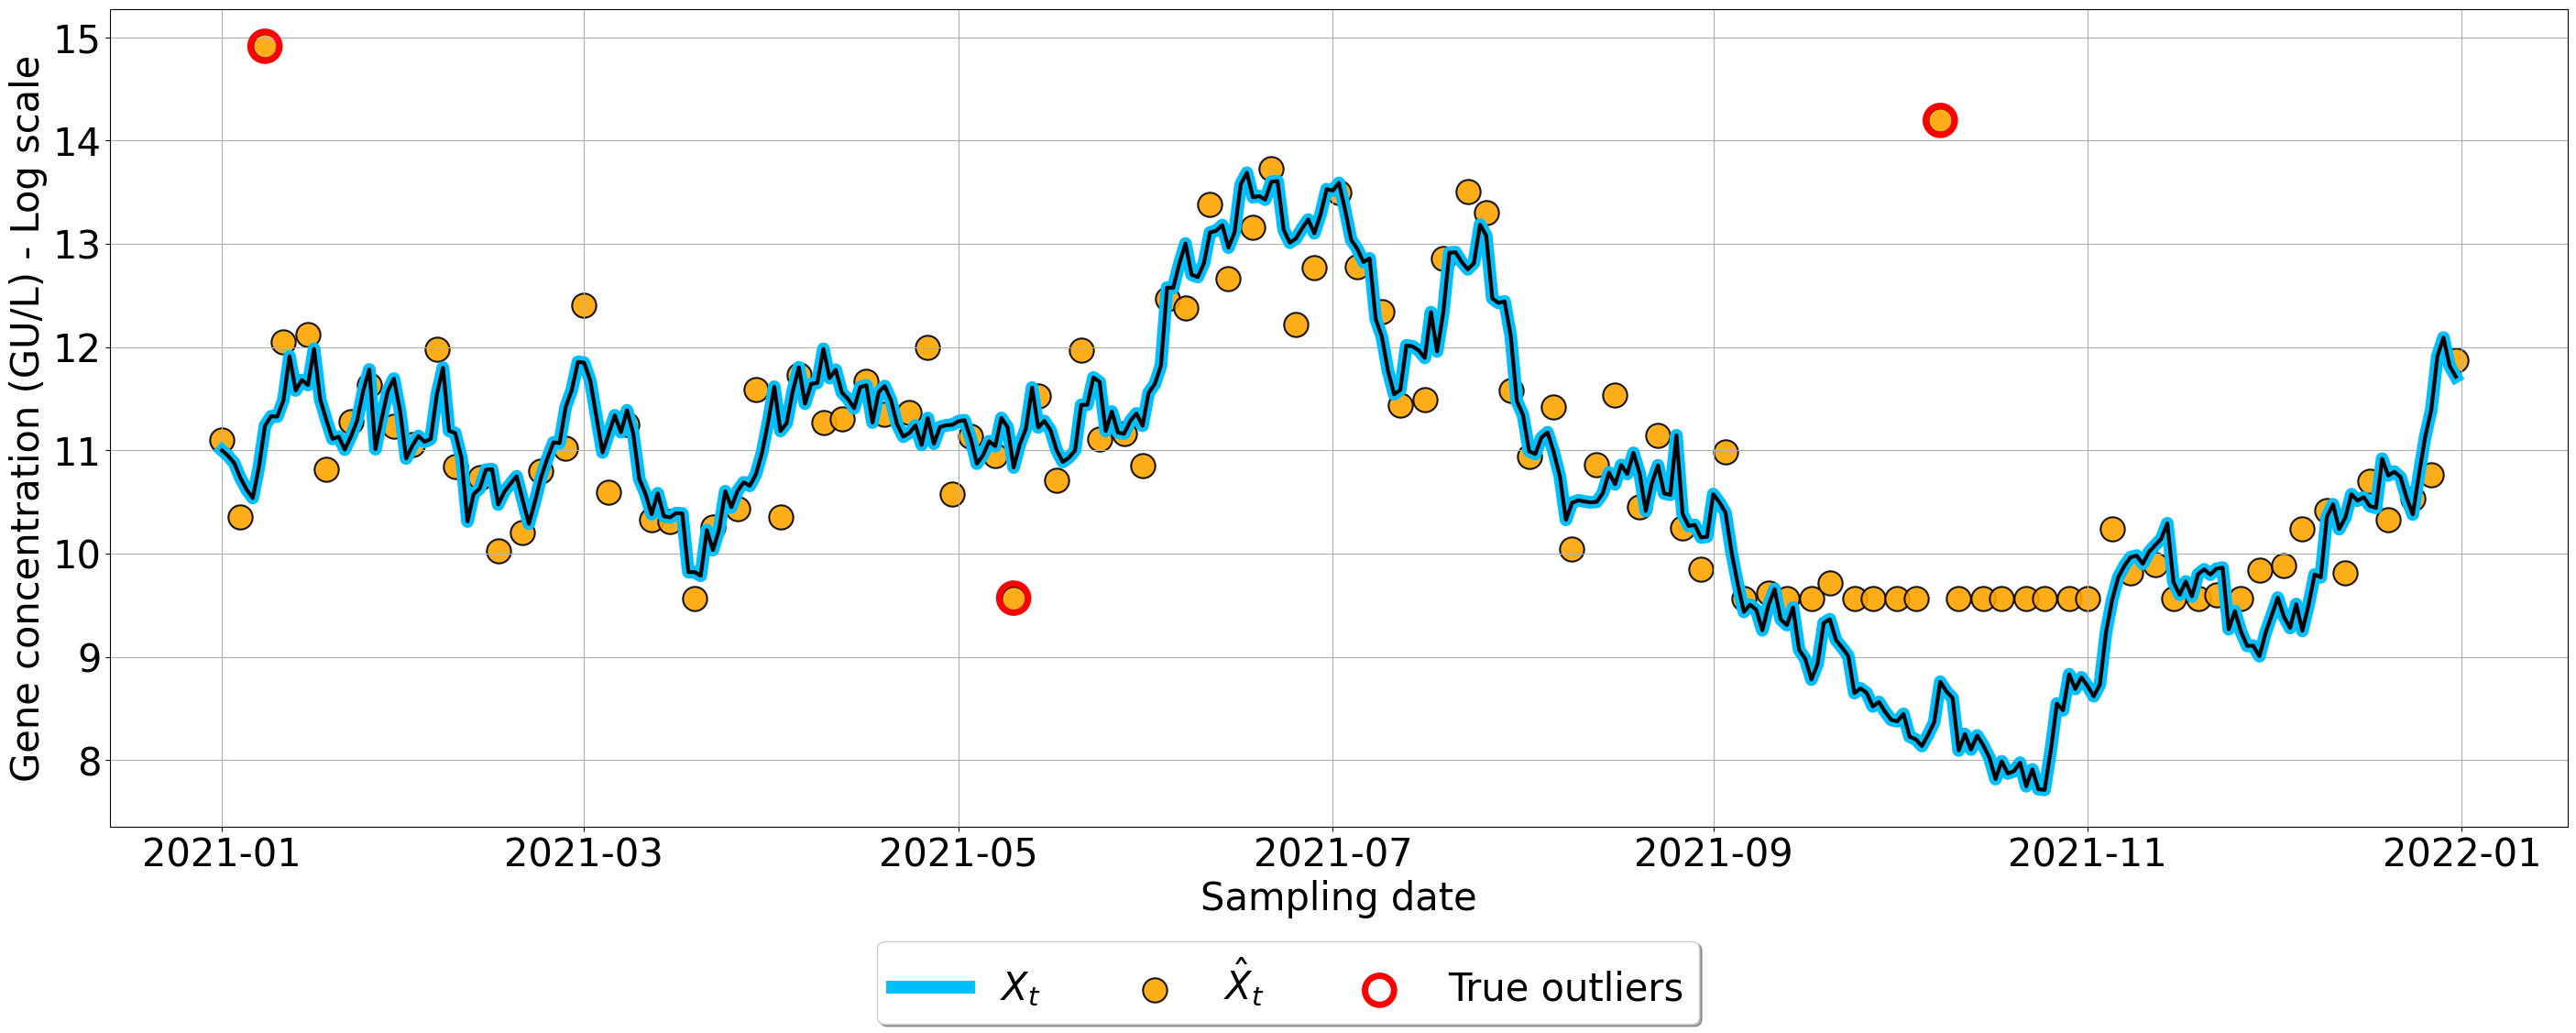

In [10]:
visualize_raw_data(df, outliers_indexes)

In [11]:
lod_vect = np.ones(df.shape[0]) * thresh
observation_vect = df.Yt.values
nb_states = 600 

t0 = time.time()
scou = SCOU(observation_vect, lod_vect=lod_vect, nb_states=nb_states)
scou.fit()
scou.predict()
scou.compute_pointwise_outlier_probabilities()
t1 = time.time()

print("Computation took " + str(t1 - t0) + "seconds.")

Optimization terminated successfully.
         Current function value: 124.998219
         Iterations: 69
         Function evaluations: 129
Computation took 6.145549774169922seconds.


In [12]:
solution = pd.read_csv('III_solution.csv', sep=";")
solution_dict = {}

for parameter in ['sigma', 'epsilon', 'p_out']:
    solution_dict[parameter] = solution[parameter].values[0]
for parameter in ['muX', 'IC95_lower', 'IC95_upper', 'pointwise_pout']:
    solution_dict[parameter] = solution[parameter].values


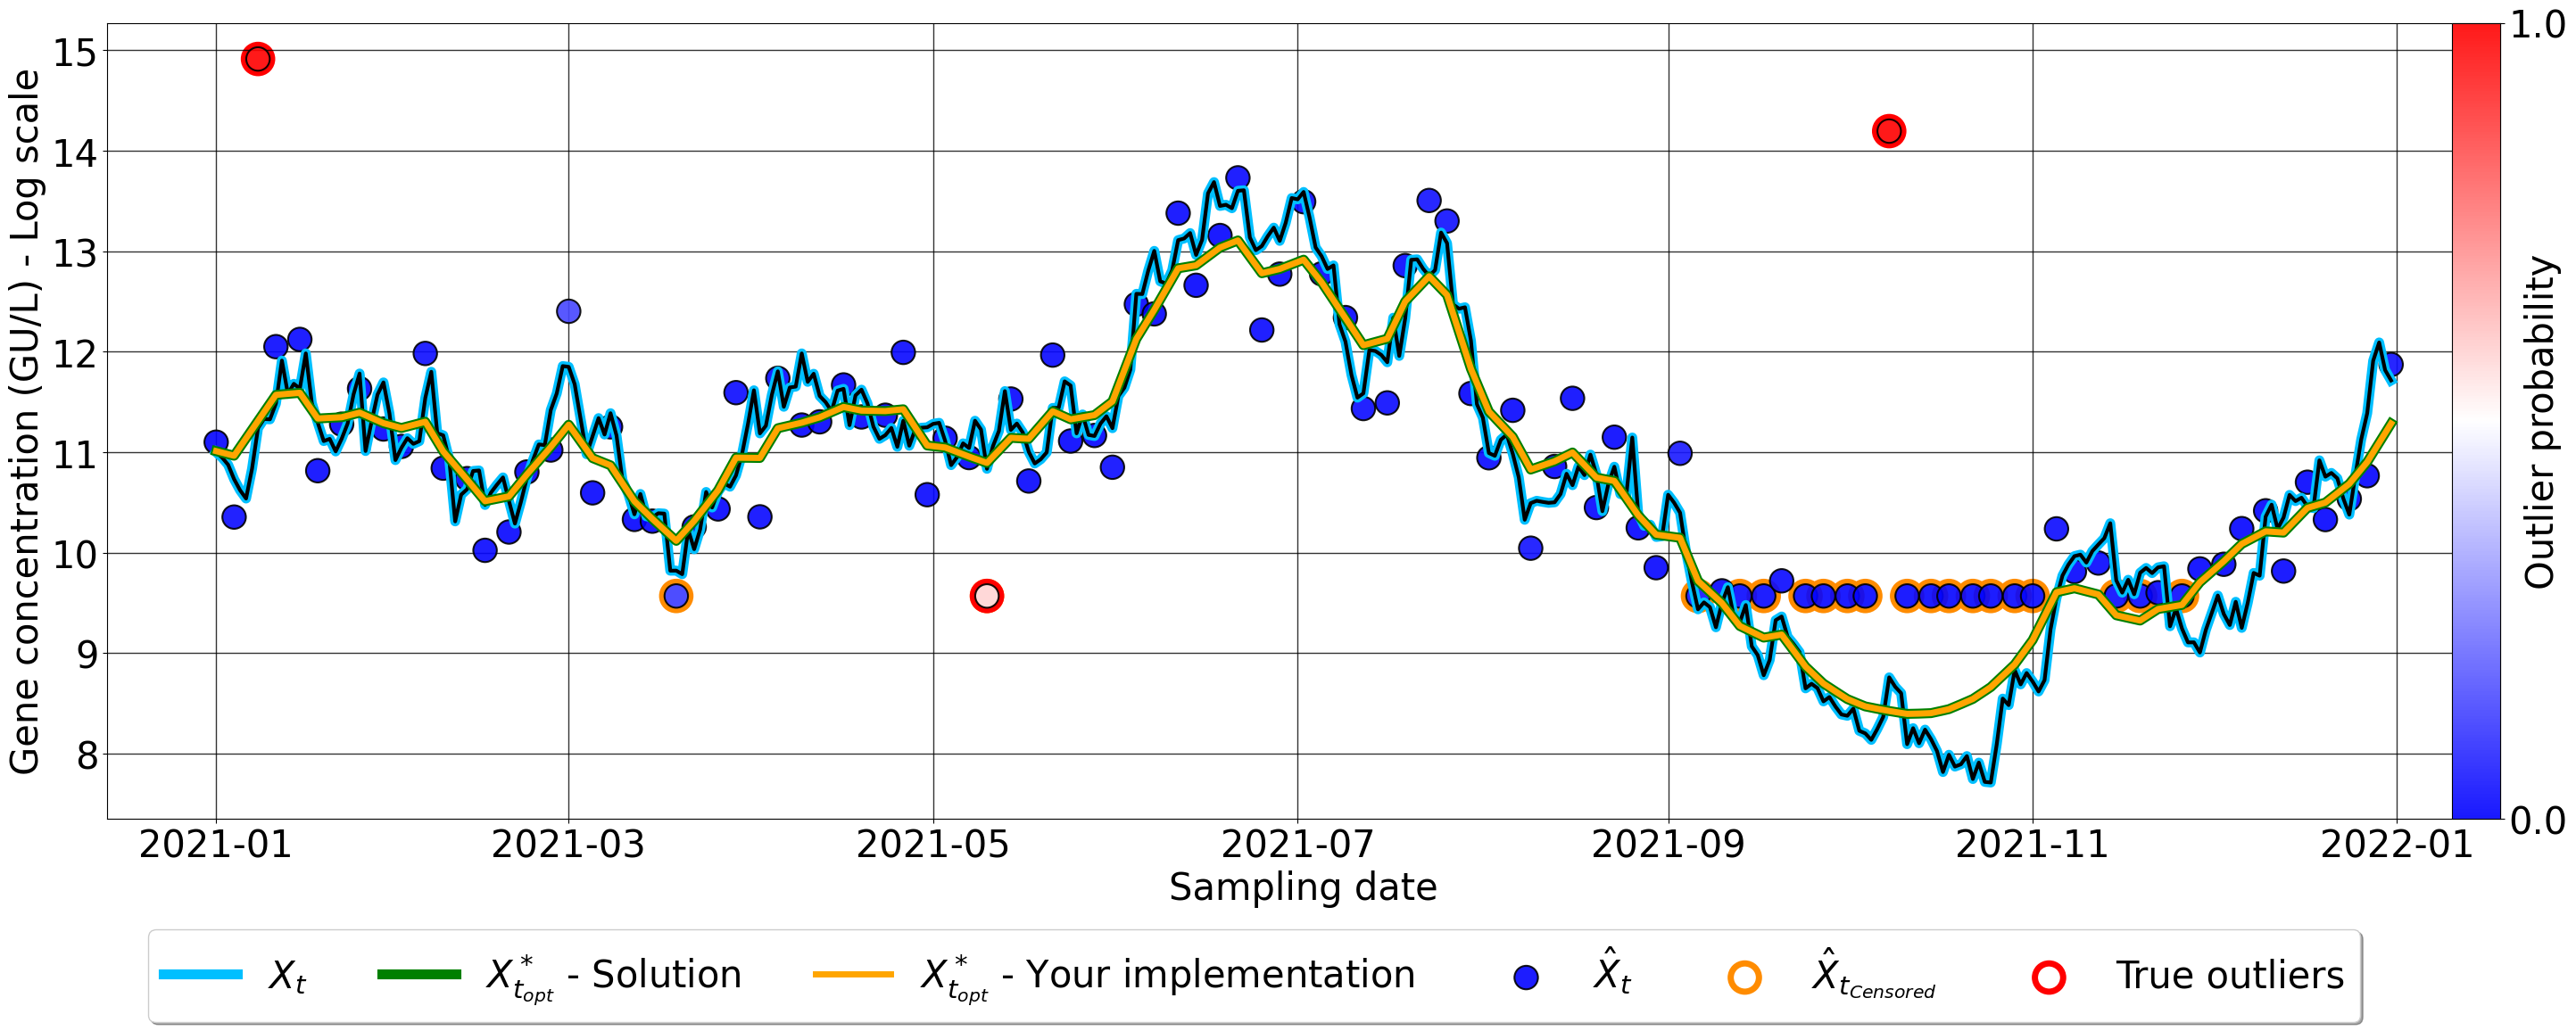

In [13]:
visualize_smoothed_data(df, outliers_indexes, scou, solution)

In [14]:
# Ne pas modifier cette cellule
rtol = 1e-2 
rtol2 = 1e-1

cmp('sigma', scou, solution_dict, rtol)
cmp('epsilon', scou, solution_dict, rtol)
cmp('p_out', scou, solution_dict, rtol)
cmp('muX', scou, solution_dict, rtol)
cmp('IC95_lower', scou, solution_dict, rtol)
cmp('IC95_upper', scou, solution_dict, rtol)
cmp('pointwise_pout', scou, solution_dict, rtol2)

sigma           | exact: True  | maxdiff: 5.551115123125783e-17
epsilon         | exact: True  | maxdiff: 0.0
p_out           | exact: True  | maxdiff: 5.551115123125783e-17
muX             | exact: True  | maxdiff: 1.7763568394002505e-15
IC95_lower      | exact: True  | maxdiff: 1.7763568394002505e-15
IC95_upper      | exact: True  | maxdiff: 1.7763568394002505e-15
pointwise_pout  | exact: True  | maxdiff: 9.80118763926896e-17


Si toutes les vérifications sont à True dans la cellule ci-dessus, c'est parfait !